In [1]:
%load_ext autoreload
%autoreload 2

# Beyond RAG: From Retrieval to Agentic Systems

Author: [Vladimir Ageev](www.linkedin.com/in/vladimir-ageev-ds)  
DS / MLE with experience in recommendation systems and NLP  
Currently involved in a project on building a RAG for a search product

## Topics and goals

1. Terminology & context
2. RAG Limitations
3. Tools
4. Agentic system


I hope this session will introduce you to:
- RAG, structured outputs
- Agents & workflows in Langgraph
- MCP
- Planning & Multi-agency

### Installing dependencies

In [ ]:
! pip install -r requirements.in

In [ ]:
! gdown gdown 1mnb0rgmciMZax21ZmoYGRlx3e7VIcNhV

In [ ]:
from IPython.display import display, Markdown
from pprint import pprint
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# RAG
## Ingestion

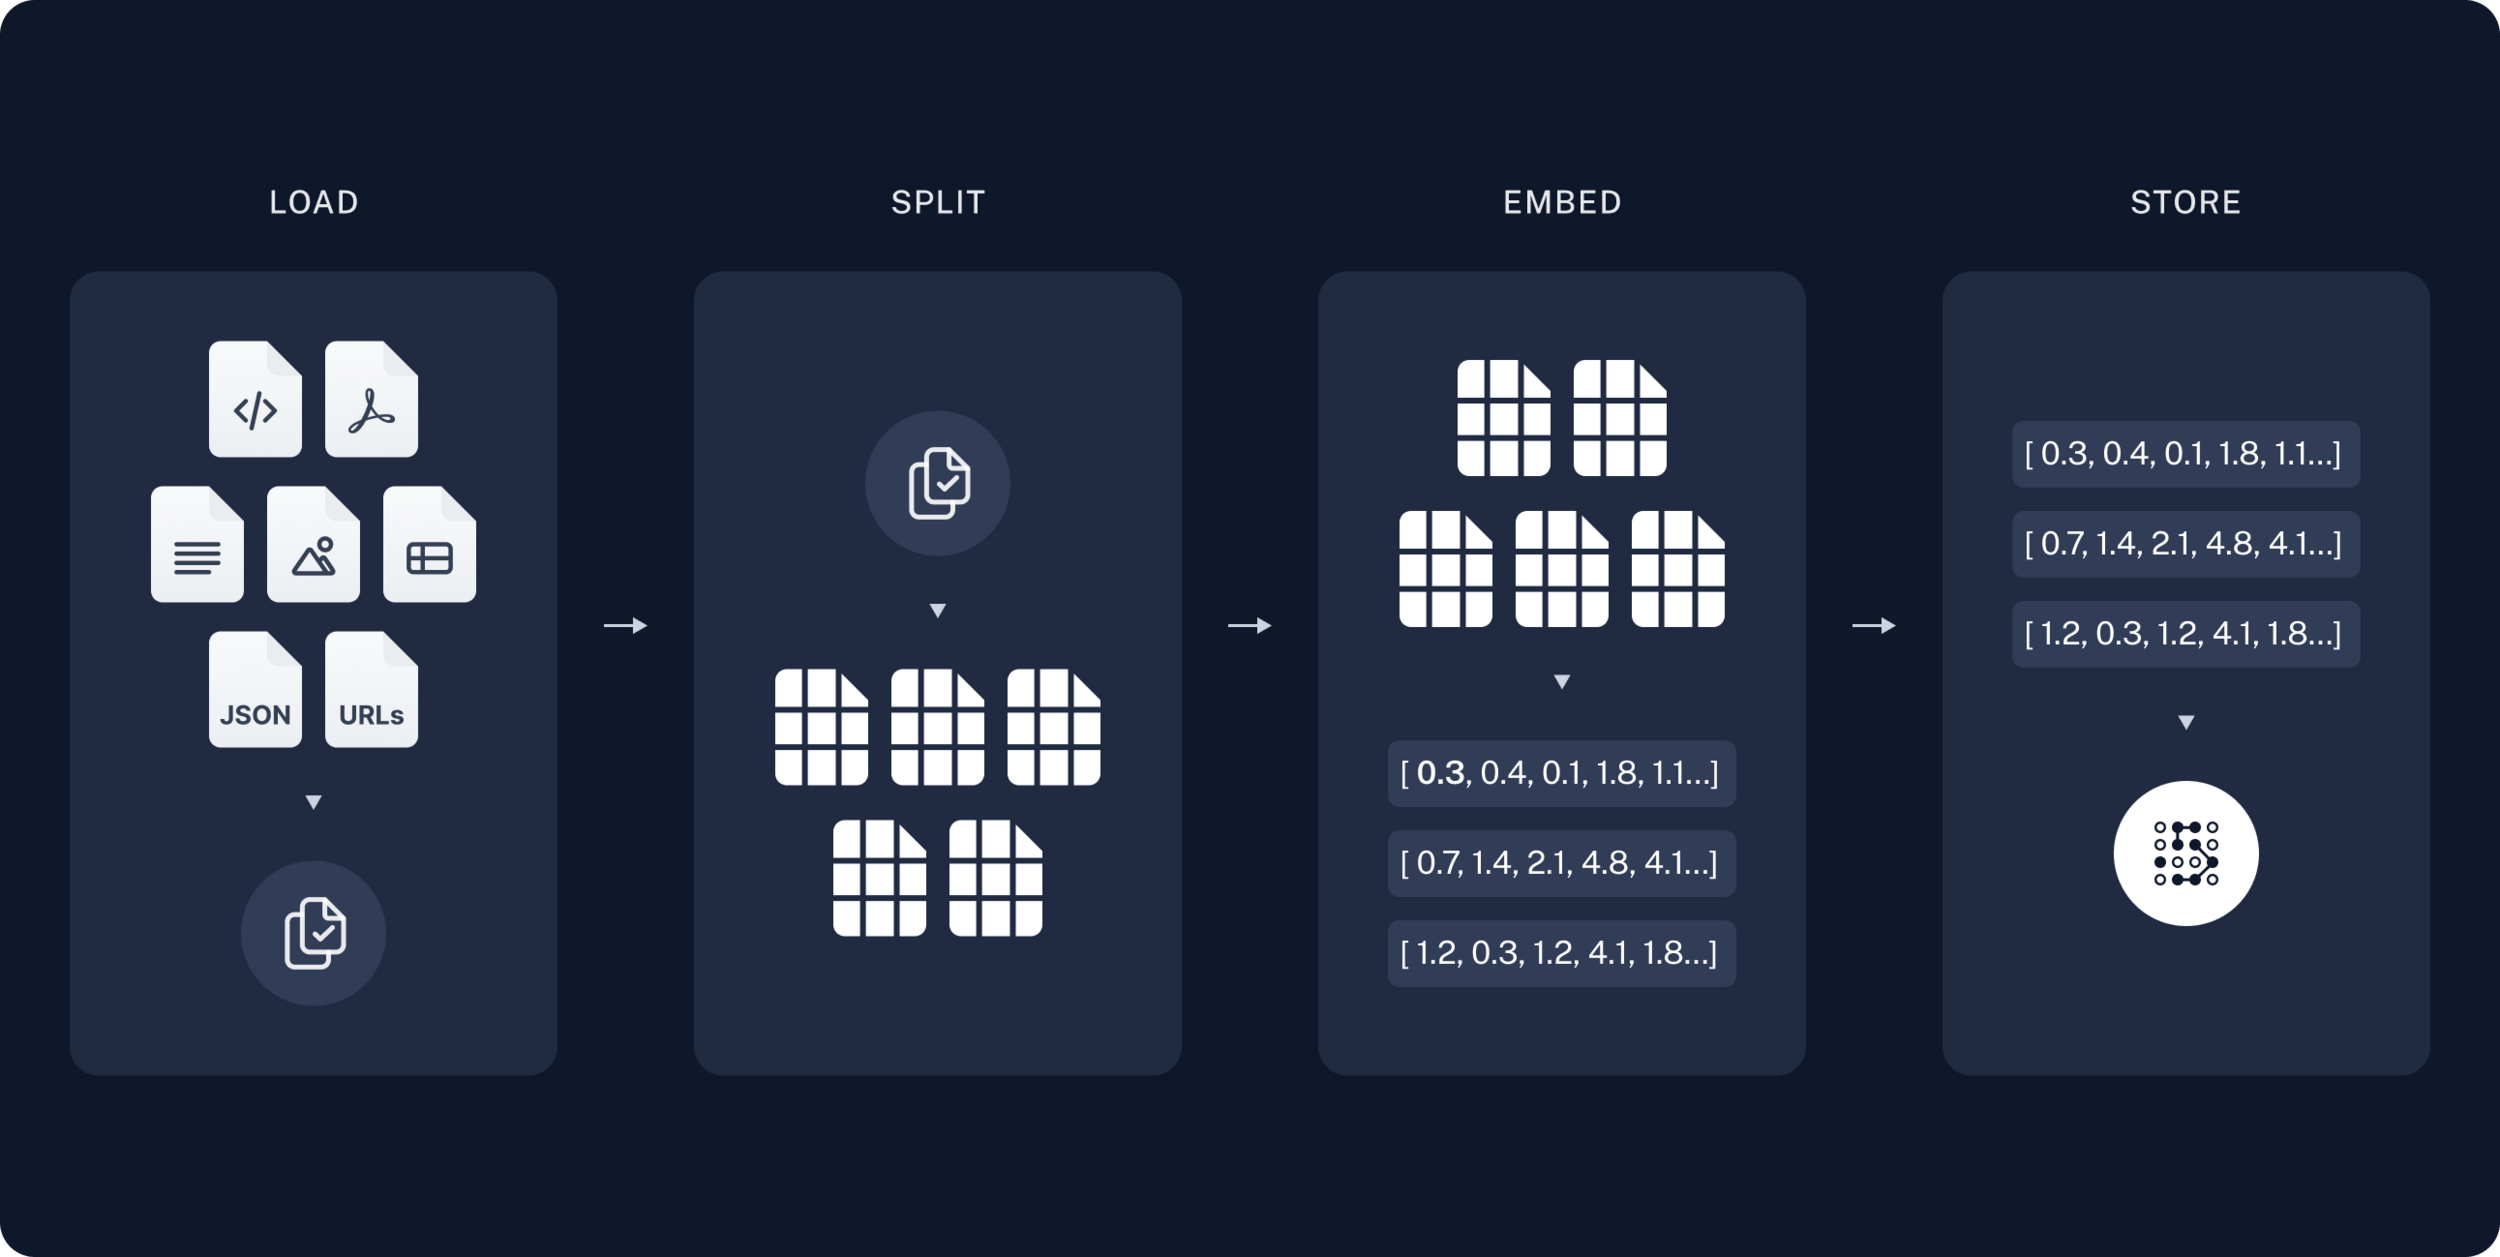

In [ ]:
### Initialize vector storage
from sentence_transformers import SentenceTransformer
from langchain_chroma import Chroma
from langchain_core.embeddings.embeddings import Embeddings
from pprint import pprint


class ArcticEmbeddings(Embeddings):
    def __init__(self, model_name, batch_size=32):
        import torch
        if torch.cuda.is_available():
            device = "cuda"
        elif torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"
        self.model = SentenceTransformer(
            model_name,
            trust_remote_code=True,
            device=device,
            model_kwargs={"torch_dtype": "float16"},
        )
        self.batch_size = batch_size

    def embed_documents(self, texts: list[str]) -> list[list[float]]:
        """Embed search docs.

        Args:
            texts: List of text to embed.

        Returns:
            List of embeddings.
        """
        return self.model.encode(texts, batch_size=self.batch_size)

    def embed_query(self, text: str) -> list[float]:
        """Embed query text.

        Args:
            text: Text to embed.

        Returns:
            Embedding.
        """
        return self.model.encode(text, batch_size=self.batch_size, prompt="query")


model_name = "Snowflake/snowflake-arctic-embed-m-v1.5"

chroma_client = Chroma(
    collection_name="wiki_chunks_30K",
    persist_directory="./chroma_30K",
    embedding_function=ArcticEmbeddings(model_name),
)

print(f"Number of snippets in DB: {chroma_client._collection.count()}")

In [ ]:
search_result = chroma_client.search(
    query="President of the United States",
    k=5,
    search_type="similarity",
)
for result in search_result:
    print("Snippets:\n```", result.page_content[:200], "```", sep="\n")
    pprint(result.metadata)

## Generation

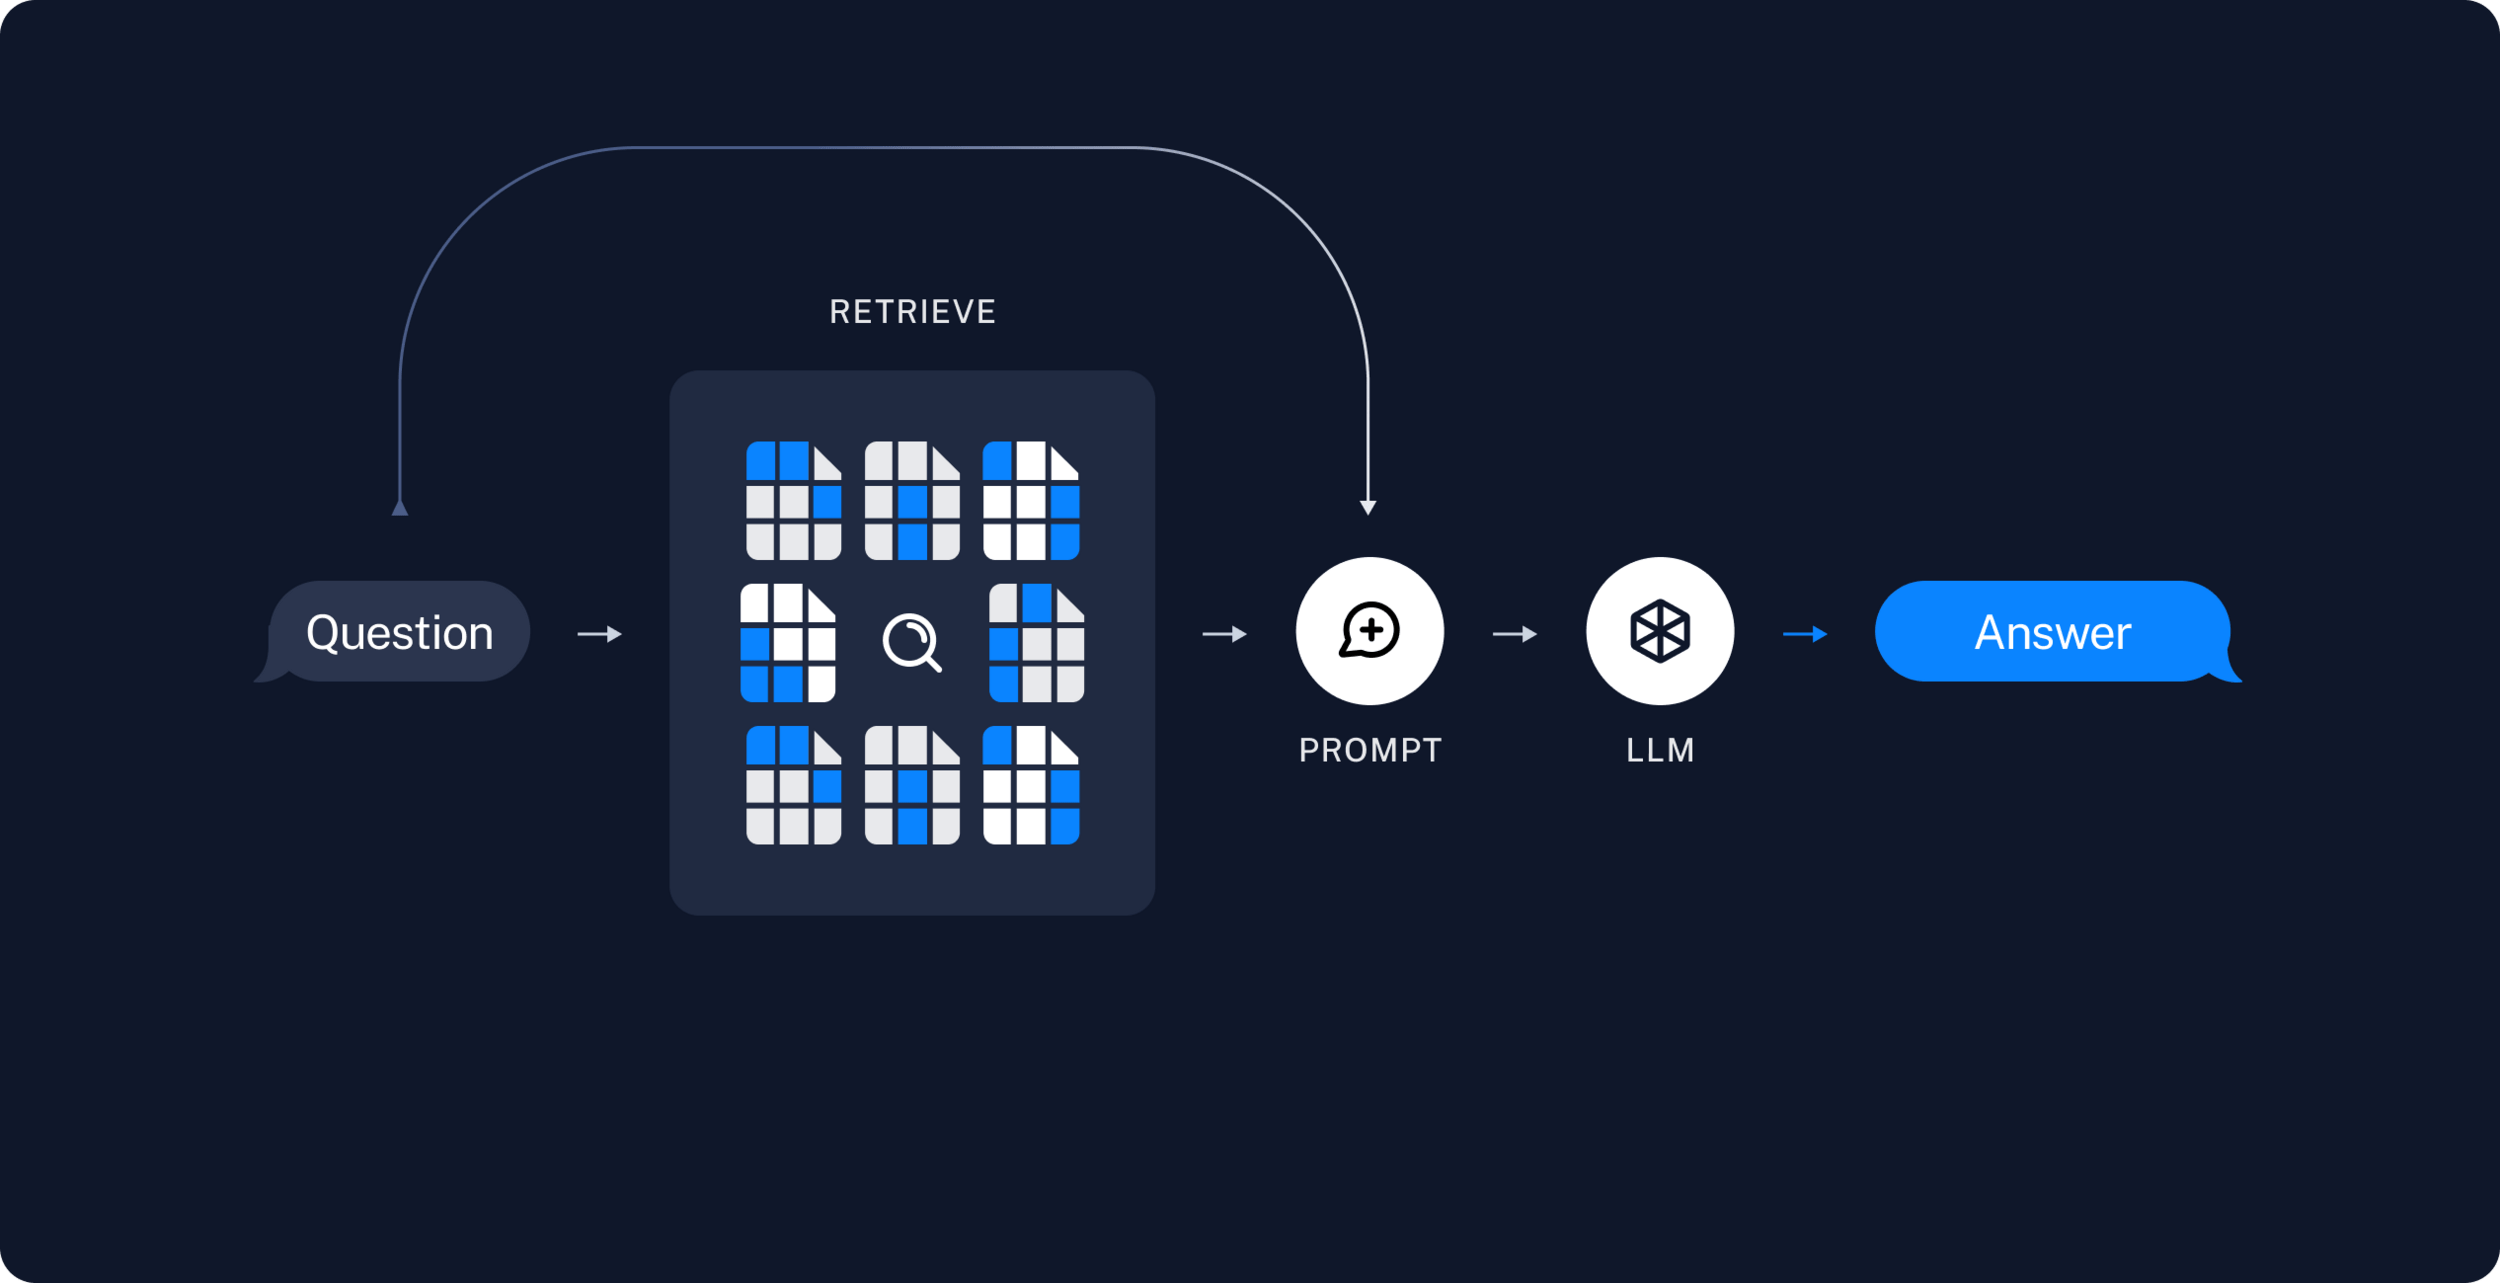

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
import asyncio
from prompts import AnswerWithCitations, QueryInput, AnswerStatement, CitationPrompt
from pydantic import SecretStr, BaseModel, Field
from ragas.prompt import PydanticPrompt
from IPython.display import Image, display
from rich.console import Console
from rich.markdown import Markdown
from rich import print_json

import nest_asyncio
nest_asyncio.apply()

from rich.theme import Theme

rich_console = Console()

Modern llm frameworks can use Pydantic models as input for structured output generation (Constrained Decoding)

It serves the following functions:
- Output schema is specified and validated
- It might improve overall quality through introduction of fields like `reason` to the answer, ordering of fields, verification fields, etc.

This is sometimes called Schema-Guided Reasoning

![](resources/schema-guidence.png)

In [ ]:
print(AnswerStatement.model_json_schema()) 

The whole prompt may be composed in a similar manner (as it is used in Ragas)

In [ ]:
print(CitationPrompt().to_string())

In [ ]:
class LLMConfig(BaseModel):
    api_key: SecretStr
    model_name: str
    temperature: int = Field(default=0)
    max_tokens: int = Field(default=4096)


class RAG:
    def __init__(self, config: LLMConfig, retriever):
        self.llm_model = ChatOpenAI(**config.model_dump()).with_structured_output(
            AnswerWithCitations
        )
        self.retriever = retriever

    def call_llm(
        self, query: str, prompt: PydanticPrompt
    ) -> tuple[str, list[Document]]:
        return asyncio.run(self.call_llm_async(query=query, prompt=prompt))

    async def call_llm_async(
        self, query: str, prompt: PydanticPrompt
    ) -> tuple[str, list[Document]]:
        context = await self.retriever.ainvoke(query)
        complete_prompt = prompt.to_string(QueryInput(question=query, context=context))
        try:
            response = await self.llm_model.ainvoke(complete_prompt)
        except Exception as e:
            print(f"Error in answer generation: {e}")
            response = AnswerWithCitations(
                statements=[
                    AnswerStatement(
                        answer_sentece="Error in generating answer.",
                        reference_url=None,
                        reference_title=None,
                    )
                ]
            )
        return response, context

In [ ]:
from pydantic import SecretStr
import os
import dotenv

dotenv.load_dotenv()
# from google.colab import userdata
api_key = SecretStr(os.getenv("OPENAI_API_KEY"))

llm_config = LLMConfig(
    api_key=api_key,
    model_name="gpt-5-mini",
    temperature=0,
    max_tokens=4096
)

retriever = chroma_client.as_retriever(
    search_type="mmr", search_kwargs={"k": 20, "fetch_k": 50, "lambda_mult": 0.8}
)

llm_client = RAG(config=llm_config, retriever=retriever)

In [ ]:
response, context = llm_client.call_llm(
    query="Who won the most gold medals in the Tokyo Olympics?",
    prompt=CitationPrompt(),
)

In [ ]:
for doc in context:
    print(f"Title: {doc.metadata['title']}")
    print(f"URL: {doc.metadata['url']}")
    print(f"Content: {doc.page_content[:100]}")
    print()

In [ ]:
pprint(response.statements)

In [ ]:
rich_console.print(Markdown(response.format_response()))

### Our RAG Limitations

1. Up-to-date facts

In [ ]:
response, context = llm_client.call_llm(
    query="Who is the King of England?",
    prompt=CitationPrompt(),
)
rich_console.print(Markdown(response.format_response()))

2. Single-turn search

In [ ]:
response, context = llm_client.call_llm(
    query="Average age of the latest 5 presidents of the United States",
    prompt=CitationPrompt(),
)
display(Markdown(response.format_response()))

3. Stateless

Cannot continue conversation 

# So, what are agents?

1. Agents are to overcome the “limitations” of LLMs. 
    - instead of training for solving the tasks, let them use tools to solve a task!

2. Anthropic / Langgraph: "Workflow" vs "Agents":
    - "**Workflows** are systems where LLMs and tools are orchestrated through predefined code paths."
    - "**Agents** are systems where LLMs dynamically direct their own processes and tool usage, maintaining control over how they accomplish tasks."
    - “**Agents** can be used for open-ended problems where it’s difficult or impossible to predict the required number of steps, and where you can’t hardcode a fixed path.“
    - **Agents** have **environment** and **feedback** from that environment (e.g. SWE Bench)

![](resources/agent_workflow.png)

3. OpenAI: "An AI system that has instructions (what it should do), guardrails (what it should not do), and access to tools (what it can do) to take action on the user’s behalf"

# Agentic system

![](resources/flow-schema-1.png)

In [ ]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import (
    BaseMessage,
    SystemMessage,
    HumanMessage,
    ToolMessage,
    AIMessage,
    get_buffer_string,
)
from typing import Literal, Sequence, Annotated, TypedDict
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import InMemorySaver
import operator
import json

## Tools

In [ ]:
from tools import tavily_search, think_tool, ConductResearch, ResearchComplete

### Retrieval as mcp tool

![](resources/flow-schema-2.png)

In [ ]:
from langchain_mcp_adapters.client import MultiServerMCPClient

mcp_config = {
    "retrieval": {
        "command": "python",
        "args": ["-m", "mcp_retrieval"],
        "transport": "stdio",
    }
}

_client = None


def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


retrieval_client = get_mcp_client()
retrieval_tools = await retrieval_client.get_tools()
for tool in retrieval_tools:
    rich_console.print(tool.description, tool.name, tool.args, sep="\n\n")

In [ ]:
search_results = await retrieval_tools[0].ainvoke(
    {"query": "Who is the King of England?", "k": 3}
)

for result in search_results:
    rich_console.print(result)

### Web search

In [ ]:
print("Description:", tavily_search.description)
print("Name:", tavily_search.name)
print("Args:", json.dumps(tavily_search.args, indent=2))

In [ ]:
query = "Who is the King of England?"
params = {"query": query, "max_results": 3, "topic": "general"}
result = tavily_search.invoke(params)

i = 0
for url, doc in result.items():
    i += 1
    title = doc.get("title", "(no title)")
    snippet = (doc.get("content", "") or "").replace("\n", " ")[:200]
    print(f"{i}. {title}\n   {url}\n   {snippet}...\n")

### Think tool

![](resources/sonnet-scores.png)

In [ ]:
print("Description:", think_tool.description, "\n\n")
print("Name:", think_tool.name, "\n\n")
print("Args:", json.dumps(think_tool.args, indent=2), "\n\n")

In [ ]:
think_tool.invoke({"reflection": "I need to search for the current King of England."})

In [ ]:
mcp_tools = await retrieval_client.get_tools()
mcp_tools_by_name = {tool.name: tool for tool in mcp_tools}
local_tools = [think_tool, tavily_search]
local_tools_by_name = {"think_tool": think_tool, "web_search": tavily_search}

## Research Subagent

![](resources/flow-schema-3.png)

In [ ]:
class SubagentState(TypedDict):
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]
    research_topic: str
    report: AnswerWithCitations
    tool_call_iterations: Annotated[int, operator.add]


class SubagentOutput(TypedDict):
    report: AnswerWithCitations
    researcher_messages: Annotated[Sequence[BaseMessage], add_messages]

![](resources/flow-schema-4.png)

In [ ]:
from prompts import subagentPrompt, SummaryPrompt, SummaryInput

async def llm_call(
    state: SubagentState,
) -> Command[Literal["generate_summary", "tools_node"]]:
    model = ChatOpenAI(model_name="gpt-5-mini", temperature=0, max_tokens=4096)
    model_with_tools = model.bind_tools(local_tools + mcp_tools)
    response = model_with_tools.invoke(
        [
            SystemMessage(
                content=subagentPrompt.format(
                    research_topic=state["research_topic"],
                )
            )
        ]
        + state["researcher_messages"]
    )

    if not response.tool_calls or state["tool_call_iterations"] >= 5:
        print("Final response generated, moving to summary.")
        return Command(
            goto="generate_summary", update={"researcher_messages": [response]}
        )
    else:
        print(f"Tool calls detected ({len(response.tool_calls)}), invoking tools node.")
        return Command(
            goto="tools_node",
            update={
                "researcher_messages": [response],
                "tool_call_iterations": state["tool_call_iterations"] + 1,
            },
        )

In [ ]:
llm_call_response = await llm_call(
    {
        "research_topic": "Genoa Cricket and Football Club",
        "tool_call_iterations": 0,
        "researcher_messages": [],
    }
)

print(llm_call_response.update)

![](resources/flow-schema-5.png)

In [ ]:
async def tools_node(state: SubagentState):
    tool_calls = state["researcher_messages"][-1].tool_calls
    mcp_tools_by_name = {tool.name: tool for tool in mcp_tools}
    local_tools_by_name = {tool.name: tool for tool in local_tools}

    async def execute_tools():
        observations = []
        for tool_call in tool_calls:
            if tool_call["name"] in local_tools_by_name:
                print(f"Invoking local tool: {tool_call['name']}")
                tool = local_tools_by_name[tool_call["name"]]
                observation = tool.invoke(tool_call["args"])

            elif tool_call["name"] in mcp_tools_by_name:
                print(
                    f"Invoking MCP tool: {tool_call['name']} with args: {tool_call['args']}"
                )
                tool = mcp_tools_by_name[tool_call["name"]]
                observation = await tool.ainvoke(tool_call["args"])
                observation = json.dumps(observation)

            observations.append(observation)

        tool_outputs = [
            ToolMessage(
                content=observation,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
            for observation, tool_call in zip(observations, tool_calls)
        ]

        return tool_outputs

    messages = await execute_tools()

    return {"researcher_messages": messages}

In [ ]:
tool_node_response = await tools_node(
    {
        "research_topic": "Genoa Cricket and Football Club",
        "tool_call_iterations": 1,
        "researcher_messages": llm_call_response.update["researcher_messages"],
    }
)

In [ ]:
for msg in tool_node_response["researcher_messages"]:
    pprint(msg.content)

In [ ]:
def generate_summary(state: SubagentState):
    model = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=4096
    ).with_structured_output(AnswerWithCitations)
    print("Generating summary report...")
    messages_list = [
        m.content
        for m in state["researcher_messages"]
        if isinstance(m, (HumanMessage, AIMessage, ToolMessage))
    ]
    prompt = SummaryPrompt().to_string(SummaryInput(messages=messages_list))

    result = model.invoke(prompt)

    return {"report": result, "researcher_messages": state["researcher_messages"]}

In [ ]:
summary_report = generate_summary(
    {
        "researcher_messages": llm_call_response.update["researcher_messages"]
        + tool_node_response["researcher_messages"],
        "tool_call_iterations": 1,
        "research_topic": "Genoa Cricket and Football Club",
    }
)

In [ ]:
rich_console.print(Markdown(summary_report["report"].format_response()))

In [ ]:
def build_subagent_graph():
    graph_builder = StateGraph(state_schema=SubagentState)
    graph_builder.add_node("llm_call", llm_call)
    graph_builder.add_node("tools_node", tools_node)
    graph_builder.add_node("generate_summary", generate_summary)

    graph_builder.add_edge(START, "llm_call")

    graph_builder.add_edge("tools_node", "llm_call")
    graph_builder.add_edge("generate_summary", END)
    return graph_builder.compile()

In [ ]:
subagent_graph = build_subagent_graph()
display(Image(subagent_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
from langfuse.langchain import CallbackHandler
from langfuse import get_client
from langfuse import Langfuse

# print(dotenv.load_dotenv())
# langfuse = Langfuse(
#   secret_key=os.getenv("LANGFUSE_SECRET_KEY"),
#   public_key=os.getenv("LANGFUSE_PUBLIC_KEY"),
#   host=os.getenv("LANGFUSE_HOST")
# )

# langfuse = get_client(public_key=os.getenv("LANGFUSE_PUBLIC_KEY"))
# langfuse_handler = CallbackHandler(public_key=os.getenv("LANGFUSE_PUBLIC_KEY"))
# langfuse.auth_check()

result = await subagent_graph.ainvoke(
    {
        "research_topic": "Who is the current reigning monarch commonly referred to as the 'King of England' (provide name and regnal title)?",
        "researcher_messages": [],
        "tool_call_iterations": 0,
    },
    # config={"callbacks": [langfuse_handler]}
)

In [ ]:
rich_console.print(Markdown(result["report"].format_response()))

# Research Supervisor

![](resources/flow-schema-6.png)

In [ ]:
class RagGraphState(MessagesState):
    search_topics: Annotated[list[str], operator.add]
    plan: Annotated[list[str], operator.add]
    supervisor_messages_buffer: Annotated[Sequence[BaseMessage], add_messages]
    clarification_rounds: Annotated[int, operator.add]
    subagents_calls: Annotated[int, operator.add]
    max_subagent_calls: Annotated[int, operator.add]
    current_task: str
    final_answer: AnswerWithCitations


class FlowInput(MessagesState):
    pass

## Delegation

![](resources/flow-schema-7.png)

In [ ]:
from prompts import supervisorPrompt

async def supervisor(
    state: RagGraphState,
) -> Command[Literal["delegate", "execute_plan"]]:
    print("Supervisor called")
    # limit of the calls achieved
    call_limit = state["subagents_calls"] >= state.get("max_subagent_calls", 5)
    # research was complete
    research_complete = False
    if len(state["supervisor_messages_buffer"]) > 0 and hasattr(
        state["supervisor_messages_buffer"][-1], "tool_calls"
    ):
        research_complete = any(
            tc["name"] == "ResearchComplete"
            for tc in state["supervisor_messages_buffer"][-1].tool_calls
        )

    if call_limit or research_complete:
        print("Call limit reached or research complete, finalizing answer.")
        return Command(goto="execute_plan")

    model = ChatOpenAI(model_name="gpt-5-mini", temperature=0, max_tokens=4096)
    model = model.bind_tools([think_tool, ResearchComplete, ConductResearch])
    prompt = supervisorPrompt.format(
        research_topic=state["current_task"],
        max_researcher_iterations=state.get("max_subagent_calls", 5),
        max_concurrent_research_units=2,
    )

    response = await model.ainvoke(
        [
            SystemMessage(content=prompt),
        ]
        + state["supervisor_messages_buffer"]
    )

    if not response.tool_calls:
        print("No tool calls detected, finalizing answer.")
        return Command(
            goto="finalize_answer", update={"supervisor_messages_buffer": [response]}
        )

    print(f"Tool calls detected ({len(response.tool_calls)}), delegating to subagent.")
    return Command(
        goto="delegate",
        update={
            "supervisor_messages_buffer": [response],
        },
    )

In [ ]:
supervision_response = await supervisor(
    {
        "subagents_calls": 0,
        "max_subagent_calls": 5,
        "current_task": "Who is King of England? Give a brief overview.",
        "supervisor_messages_buffer": [],
    }
)

In [ ]:
supervision_response.goto

In [ ]:
for m in supervision_response.update["supervisor_messages_buffer"]:
    print(m)

![](resources/flow-schema-8.png)

In [ ]:
import prompts


async def delegate(state: RagGraphState) -> Command[Literal["supervisor", "__end__"]]:
    print("Delegate called")
    last_message = state["supervisor_messages_buffer"][-1]
    tool_messages = []
    try:
        # Separate think_tool calls from ConductResearch calls
        think_tool_calls = [
            tool_call
            for tool_call in last_message.tool_calls
            if tool_call["name"] == "think_tool"
        ]

        conduct_research_calls = [
            tool_call
            for tool_call in last_message.tool_calls
            if tool_call["name"] == "ConductResearch"
        ]

        # Handle think_tool calls (synchronous)
        for tool_call in think_tool_calls:
            observation = think_tool.invoke(tool_call["args"])
            tool_messages.append(
                ToolMessage(
                    content=observation,
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        # Handle ConductResearch calls (asynchronous)
        if conduct_research_calls:
            # Launch parallel research agents
            coros = [
                subagent_graph.ainvoke(
                    {
                        "researcher_messages": [
                            HumanMessage(content=tool_call["args"]["research_topic"])
                        ],
                        "research_topic": tool_call["args"]["research_topic"],
                    }
                )
                for tool_call in conduct_research_calls
            ]

            # Wait for all research to complete
            tool_results = await asyncio.gather(*coros)
            research_tool_messages = []
            for result, tool_call in zip(tool_results, conduct_research_calls):
                result_content = result.get(
                    "report", "Error synthesizing research report"
                )
                if isinstance(result_content, prompts.AnswerWithCitations):
                    result_content = result_content.model_dump_json()
                research_tool_messages.append(
                    ToolMessage(
                        content=result_content,
                        name=tool_call["name"],
                        tool_call_id=tool_call["id"],
                    )
                )
            tool_messages.extend(research_tool_messages)
    except Exception as e:
        print(f"Error in delegate execution: {e}")
        tool_messages.append(
            ToolMessage(
                content=f"Error in delegate execution: {e}",
                name="Error",
                tool_call_id="error",
            )
        )
        return Command(goto="__end__")

    return Command(
        goto="supervisor",
        update={
            "supervisor_messages_buffer": tool_messages,
            "subagents_calls": state["subagents_calls"] + len(conduct_research_calls),
        },
    )

In [ ]:
await delegate(
    {
        "subagents_calls": 0,
        "max_subagent_calls": 5,
        "current_task": "Who is King of England? Give a brief overview.",
        "supervisor_messages_buffer": supervision_response.update[
            "supervisor_messages_buffer"
        ],
    }
)

In [ ]:
def execute_plan(
    state: RagGraphState,
) -> Command[Literal["supervisor", "finalize_answer"]]:
    print("Execute plan called with state plan:", state["plan"])
    if state["plan"]:
        current_task = state["plan"].pop(0)
        return Command(
            goto="supervisor",
            update={
                "current_task": current_task,
                "subagents_calls": 0,
                "plan": state["plan"],
                "max_subagent_calls": 5,
                "supervisor_messages_buffer": state.get(
                    "supervisor_messages_buffer", []
                ),
            },
        )
    return Command(goto="finalize_answer")

In [ ]:
plan = ["task1", "task2"]
for i in range(3):
    response = execute_plan(
        {
            "plan": plan,
        }
    )
    plan = response.update["plan"] if response.update else []
    print(response)

In [ ]:
from prompts import FinalReportPrompt, AnswersCollection


def finalize_answer(state: RagGraphState):
    model = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=16000
    ).with_structured_output(AnswerWithCitations)
    print("Generating summary report...")
    print(state["supervisor_messages_buffer"])
    messages_list = [
        AnswerWithCitations.model_validate_json(m.content)
        for m in state["supervisor_messages_buffer"]
        if isinstance(m, ToolMessage) and m.name == "ConductResearch"
    ]
    prompt = FinalReportPrompt().to_string(AnswersCollection(answers=messages_list))

    result = model.invoke(prompt)

    return {"final_answer": result}

In [ ]:
def build_supervisor_graph():
    supervisor_builder = StateGraph(RagGraphState)
    supervisor_builder.add_node("execute_plan", execute_plan)
    supervisor_builder.add_node("supervisor", supervisor)
    supervisor_builder.add_node("delegate", delegate)
    supervisor_builder.add_node("finalize_answer", finalize_answer)

    supervisor_builder.add_edge(START, "execute_plan")
    supervisor_agent = supervisor_builder.compile()
    return supervisor_agent


supervisor_graph = build_supervisor_graph()

In [ ]:
display(Image(supervisor_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
result = await supervisor_graph.ainvoke(
    {
        "plan": ["research who is the King of England"],
        "supervisor_messages_buffer": [
            HumanMessage(content="I want to find out who is the King of England")
        ],
        "current_task": "who is the King of England",
    }
)

In [ ]:
rich_console.print(Markdown(result["final_answer"].format_response()))

## Scoping

In [ ]:
from prompts import ClarificationInput, ClarificationOutput, ClarificationPrompt


def clarify_node(state: RagGraphState) -> Command[Literal["__end__"]]:
    llm_client = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=4096
    ).with_structured_output(ClarificationOutput)

    messages_list = [
        m.content for m in state["messages"][-5:] if isinstance(m, HumanMessage)
    ]
    result = llm_client.invoke(
        ClarificationPrompt().to_string(ClarificationInput(messages=messages_list))
    )

    if state["clarification_rounds"] > 1:
        return {
            f"messages": [
                AIMessage(
                    content=f"Your request is clear. Will proceed with research on {result.final_statements}."
                )
            ]
        }

    if result.clarification_is_required:
        return Command(
            goto="__end__",
            update={
                "clarification_rounds": state["clarification_rounds"] + 1,
                "messages": [AIMessage(content=result.clarifying_question)],
            },
        )
    return Command(
        goto="__end__",
        update={
            "messages": [
                AIMessage(
                    content=f"Your request is clear. Will proceed with research on {result.final_statements}."
                )
            ],
            "search_topics": result.final_statements,
            "clarification_rounds": state["clarification_rounds"],
        },
    )


def build_scoper_graph():
    checkpointer = InMemorySaver()
    graph_builder = StateGraph(
        state_schema=RagGraphState,
        input_schema=FlowInput,
    )
    graph_builder.add_node("clarify_node", clarify_node)
    graph_builder.add_edge(START, "clarify_node")
    graph_builder.add_edge("clarify_node", END)
    return graph_builder.compile(checkpointer=checkpointer)

In [ ]:
scoper_graph = build_scoper_graph()
display(Image(scoper_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
thread = {"configurable": {"thread_id": "1"}}
result = scoper_graph.invoke(
    {"messages": [HumanMessage(content="I want to research new bikes")]}, config=thread
)
result["messages"]

In [ ]:
result = scoper_graph.invoke(
    {"messages": [HumanMessage(content="I want to find a new gravel bike")]},
    config=thread,
)
result["messages"]

In [ ]:
# result = scoper_graph.invoke({"messages": [HumanMessage(content="And advice would be nice")]}, config=thread)
# result['messages']

In [ ]:
result["search_topics"]

## Planning

In [ ]:
from prompts import PlannerOutput, PlannerInput, PlanPrompt


def generate_tasks(state: RagGraphState):
    llm_client = ChatOpenAI(
        model_name="gpt-5-mini", temperature=0, max_tokens=4096
    ).with_structured_output(PlannerOutput)

    response = llm_client.invoke(
        PlanPrompt().to_string(
            PlannerInput(
                search_topics=state["search_topics"],
                messages=get_buffer_string(state["messages"]),
            )
        )
    )

    return {
        "plan": response.plan,
        "messages": [AIMessage(content=f"Generated plan: " + ", ".join(response.plan))],
        "max_subagent_calls": 5,
        "subagents_calls": 0,
    }


def build_planner_graph():
    checkpointer = InMemorySaver()
    graph_builder = StateGraph(
        state_schema=RagGraphState,
        input_schema=FlowInput,
    )
    graph_builder.add_node("clarify_node", clarify_node)
    graph_builder.add_node("generate_tasks", generate_tasks)

    graph_builder.add_edge(START, "clarify_node")
    graph_builder.add_edge("clarify_node", "generate_tasks")
    graph_builder.add_edge("generate_tasks", END)
    return graph_builder.compile(checkpointer=checkpointer)

In [ ]:
planner_graph = build_planner_graph()
display(Image(planner_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
thread = {"configurable": {"thread_id": "2"}}
result = planner_graph.invoke(
    {"messages": [HumanMessage(content="Who is the King of England?")]}, config=thread
)
result["messages"]

In [ ]:
result["plan"]

## Full graph

In [ ]:
def build_full_graph():
    graph_builder = StateGraph(RagGraphState, input_schema=FlowInput)
    checkpointer = InMemorySaver()

    graph_builder.add_node("clarify_node", clarify_node)
    graph_builder.add_node("generate_tasks", generate_tasks)
    graph_builder.add_node("supervisor_graph", supervisor_graph)

    graph_builder.add_edge(START, "clarify_node")
    graph_builder.add_edge("clarify_node", "generate_tasks")
    graph_builder.add_edge("generate_tasks", "supervisor_graph")
    return graph_builder.compile(checkpointer=checkpointer)

In [ ]:
agentic_rag = build_full_graph()
display(Image(agentic_rag.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
thread = {"configurable": {"thread_id": "102"},
          "recursion_limit": 50, 
        #   "callbacks": [langfuse_handler]
          }
result = await agentic_rag.ainvoke(
    {
        "messages": [
            HumanMessage(content="I am looking for a new bike")
        ]
    },
    config=thread
)

In [ ]:
display(Markdown(result["final_answer"]))

# References

1. [deep_research_from_scratch](https://github.com/langchain-ai/deep_research_from_scratch)
2. [workflows and agents](https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/workflows.md)
3. [anthropic-cookbook](https://github.com/anthropics/anthropic-cookbook/tree/main/patterns/agents)
4. [Build an MCP Server - Model Context Protocol](https://modelcontextprotocol.io/quickstart/server)
5. [Building Effective AI Agents \ Anthropic](https://www.anthropic.com/engineering/building-effective-agents)
6. [How we built our multi-agent research system \ Anthropic](https://www.anthropic.com/engineering/multi-agent-research-system)
7. [Tavily](https://docs.tavily.com/documentation/quickstart)
8. [Tools in Langchain](https://python.langchain.com/docs/concepts/tools/)
9. [openai agents patterns](https://github.com/openai/openai-agents-python/tree/main/examples/agent_patterns)
10. [openai agents guide](https://platform.openai.com/docs/guides/agents)  
11. [Schema-Guided Reasoning (SGR)](https://abdullin.com/schema-guided-reasoning/)  
12. [Trace and Evaluate LangGraph Agents - Langfuse](https://langfuse.com/guides/cookbook/example_langgraph_agents)  